**NB#2** 

## **Introduction**

I'm currently in the start of ML journey and trying to understand and explore regression techniques. Though this competition targets on advance regression techniques, I just want to apply Stats models OLS regression technique which I think is the initial and basic regression technique followed by anyone who is starting to learn the regression techniques. Please UPVOTE if you like the notebook and leave comment if any thing need to be corrected

## **1. About the data**
a. Before starting to proceed, as you all know it is necessary to have a glance over the training and testing data spread sheets provided. As a beginner in ML and without domain knowledge I know it is not that easy to infer anything or there would be a question what to infer spending atleast 15 mins simply staring at the training or testing data. Nevertheless, atleast it is better to know that we are going to predict the SalePrice (of House) based on different kinds of parameters or features given.

b. With data_description.txt, we can try to see what are the different categorical variables provided and what are the different possible values for each categorical variable. 

c. In layman terms - we can try to think what are the different parameters we personally consider while buying a new house (like square feet, parking facilities, distance to workplace, distance to near by bus terminal, distance to your kid's school etc.). we can relate these parameters by looking at the spreadsheet and then proceed to code with what we understand. As a beginner I can promise, you will get to know what to consider and what to ignore from the power of EDA

## **2. Input data load**

In [ ]:
#Importing Python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set()

In [ ]:
#Loading the training data
train_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
pd.set_option("display.max_columns", None) #helps to display all columns in the data frame
train_df.head()

In [ ]:
#Loading the testing data
test_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
test_df.head()

## **3. Exploratory Data Analysis (EDA):**
### **a. Handling missing values**

In [ ]:
#To check no of columns and no of rows present train and test data
print(train_df.shape)
print(test_df.shape)

From the above result we can say train data has one additional column when compared to test data. As we know that additional column would be 'SalePrice' which is the target variable. We will just cross check if there are any column mismatches other than SalePrice

In [ ]:
train_df.columns.drop('SalePrice') == test_df.columns #Checking to see if there is difference in columns other than SalePrice

No column mismatches found. Now see if SalePrice is having null or NaN values in any row. If so, we shall remove the respective row from the train data as it may not be useful for our prediction

In [ ]:
train_df['SalePrice'].isnull().sum() #helps to find null value. Outputs the sum of total null values available in SalePrice column

Luckily, there is no null value in SalePrice. Hence for now, we can ignore this column and perform missing value analysis all together for train and test data for the remaining columns

In [ ]:
all_df = pd.concat([train_df.drop('SalePrice', axis=1), test_df], axis=0, sort=False) #Merge train and test data by ignoring SalePrice
all_df.head()

In [ ]:
len(all_df) #find total no of rows

In [ ]:
nan_count = all_df.isnull().sum().sort_values(ascending=False)[all_df.isnull().sum() > 0] #get the count of null values in every column
nan_count.head()

In [ ]:
data_type = all_df.dtypes #get data type of every column
data_type.head()

In [ ]:
#concatenate nan_count and data_type in a single table
nan_table = pd.concat([nan_count, data_type], axis=1, keys=['nan_count', 'data_type'])
nan_table

In the above table NaN values are seen under nan_count. The reason is, those fields does not have null/NaN values. Hence it is good to drop those variables

In [ ]:
nan_table.dropna(inplace=True) #drops rows with nan_count as NaN

In [ ]:
# Sort the nan_table fields based on data_type and nan_count 
# This is just to group data types together and sort the nan_count based on ascending order
nan_table = nan_table.sort_values(['data_type', 'nan_count'])
nan_table

1. Now we have found the no of null values and it is necessary to replace them with some valid value
2. How do we find a valid value for every column ? That is why, we have the data_type column added
3. If data_type is numeric, we shall go with finding the median of the respective column and replace the NaN cell with this median value/ middle value
4. If data_type is object/non-numeric, we shall go with finding the value which occured most of the times. We call this as mode
5. We will also find the percentage of NaN values for each variable

**Note:** I see people using different approaches in filling the best fit value. I went with above approach as I'm more comfortable with this

In [ ]:
nan_table[['favourable_value', 'nan_percentage']] = [' ', 0.0] #adding a new column to get the best fit value and percentage of nan_values

for i, row in nan_table.iterrows():
    nan_table.at[i, 'nan_percentage'] = (nan_table.loc[i].nan_count/len(all_df)) * 100  #find percentage of nan_count
    if all_df[i].dtype == 'float64':
        nan_table.at[i, 'favourable_value'] = all_df[i].median() #find median value and append to nan_table
        
    elif all_df[i].dtype == 'object':
        nan_table.at[i, 'favourable_value'] = all_df[i].mode().values[0] #find mode value and append to nan_table
    
nan_table      

1. We will use the favourable_value to update the cells with NaN for the respective columns


2. If you could see the favourable_value for the fields with data_type as float_64, the maximum value in nan_percentage(no of NaN values out of total no of rows in the data frame corresponding to a particular field) is  16.64
3. So we simply go ahead and replace the NaN cells with the favourable_value for the fields with data_type as float_64


4. Similarily the fields with data_type as object are categorical variables and need to be handled with care.
5. It is necessary to look at the data description(data_description.txt) for every categorical variable to know what are the available values
6. If the list of available values has 'NA' (Not Applicable or Not Available) - it is better to go with 'NA' rather than using the mode value because 'NA' has strong relation with NaN intuitively
7. Below are list of fields that need to have 'NA' as the favourable value

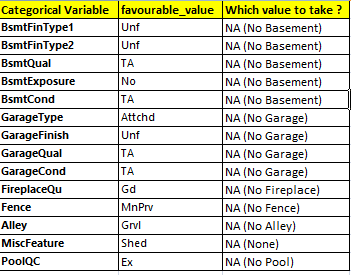


8. Now we can update the favourable value in nan_table

In [ ]:
#define an array containing list of fields whose favourable_value can be updated with 'NA'
arr_na = ['BsmtFinType1','BsmtFinType2','BsmtQual','BsmtExposure','BsmtCond','GarageType'
,'GarageFinish','GarageQual','GarageCond','FireplaceQu','Fence','Alley','MiscFeature','PoolQC']

#define a search function
def search(array, data):
    for i in range(len(array)):
        if array[i] == data:
            return True
    return False

for i, row in nan_table.iterrows():
    if nan_table.loc[i].data_type == 'float64':
        all_df[i].fillna(nan_table.loc[i].favourable_value, inplace=True) #update NaN values in the data frame with the favourable_value from nan_table for numeric fields
    
    else:
        if search(arr_na, i):
            all_df[i].fillna('NA', inplace=True) #update NaN values in the data frame with 'NA' with respect to the fields in arr_na
            nan_table.at[i, 'favourable_value'] = 'NA' #Override the favourable_value in nan_table just for our understanding or visibility
        
        else:
            all_df[i].fillna(nan_table.loc[i].favourable_value, inplace=True) #update NaN values in the data frame with the favourable_value from nan_table for other categorical fields

In [ ]:
all_df.isnull().sum().max() #To find if there is any null values present in the updated data frame. If value is 0, there is no NaN values found

In [ ]:
nan_table #displaying the table just to see what is latest favourable_value used

1. Now coming to nan_percentage. Can you think about the fields like Fence, Alley, MiscFeature, PoolQC from nan_table. 
2. What is the use of having 'NA' in more than 80% of the rows? 
3. Are these fields going to contribute in SalePrice prediction? Definitely not
4. Therefore it is good to remove these fields from the dataframe

In [ ]:
for i,row in nan_table.iterrows():
    if nan_table.at[i, 'nan_percentage'] >= 80:
        all_df.drop(i,axis=1,inplace=True) #drops columns with nan_percentage more than 80

all_df.columns

### **b. Correlation Analysis**

In [ ]:
train_df_no_nan = all_df[:len(train_df)] #separating the training data

In [ ]:
train_df_no_nan['SalePrice'] = train_df['SalePrice'] #getting the SalePrice column for analysis
train_df_no_nan.head()

1. Now, we need to perform correlation analysis with respect to SalePrice and all the numeric columns in the training dataframe
2. This would provide us some insights on the columns which has good correlation with SalePrice

In [ ]:
spcorr = train_df_no_nan.corr() #Calculate the correlation between every feature with the other
highly_corr_features = spcorr.index[abs(spcorr['SalePrice']) > 0.3] #Extracting features that have more than 30% correlation with SalePrice
plt.figure(figsize=(15,15)) #set the size of the heat map
g = sns.heatmap(train_df_no_nan[highly_corr_features].corr(),annot=True,cmap="RdYlGn") #create heatmap with respect to highly correlated features and display the correlation percentage with 3 different colours 'Red,Yellow,Green'

1. If you see the heatmap above, we could say TotalBsmtSF vs 1stFlrSF correlation percentage is 0.82 or 82%
2. No multicollinearity is one of the regression assumption that need to be satisfied.
3. As TotalBsmtSF and 1stFlrSF are highly correlated with each, to satisfy **"No multicollinearity"**, we must drop one of the variable. I would like dropping TotalBsmtSF
4. Similarily high correlation in seen in GarageCars vs GarageArea. Since GarageCars has a bit high correlation with target variable - SalePrice, we can drop GarageArea from the data frame
5. Similarily we will drop TotRmsAbvGrd as it has high correlation with GrLivArea
6. Same can apply for YearBuilt vs GarageYrBlt. As it is understood, knowing GarageYrBlt will not have much impact in SalePrice. Hence we can drop it

In [ ]:
desired_numeric_features = highly_corr_features.drop(['TotalBsmtSF', 'GarageArea', 'TotRmsAbvGrd', 'GarageYrBlt'])
desired_numeric_features

**Data Visualization - SalePrice vs Desired_numeric_features**

In [ ]:
fig, axs = plt.subplots(5,3,figsize=(20,20))

#iterating between each desired independent variable vs SalePrice

for i, ax in enumerate(fig.axes): 
    ax.scatter(train_df_no_nan[desired_numeric_features[i]], train_df_no_nan['SalePrice'])
    ax.set_title(desired_numeric_features[i] + ' vs SalePrice')
    ax.set_xlabel(desired_numeric_features[i])
    ax.set_ylabel('SalePrice')

fig.tight_layout(pad=2.0) #pad is used to provide spaces between each plot
plt.show()

Each plot above shows some linearity between feature variable and target variable satisfying one of the Regression assumption **Linearity**

### **c. Skewness correction**
Now it is necessary to correct **skewness** to remove the impact of outliers in the model. Any value beyond +- 0.5 need to be fixed


In [ ]:
from scipy.stats import norm, skew #importing package for skewness correction

#creating a function a identify skewness and fix it
def skew_fix(dframe, feat, run):
    if run == 'train':
        skewed_features = dframe[feat].apply(lambda x:skew(x)).sort_values(ascending=False)   #calculate skewness
        global highly_skewed
        highly_skewed = skewed_features[abs(skewed_features) > 0.5]    #fitering features having skewness beyond +-0.5
        print(highly_skewed)
    
    no_skew = dframe #just for initialization or declaration
    for i in highly_skewed.index:
        no_skew[i] = np.log1p(dframe[i]) #performing log transformation to correct the skewness
        
    return no_skew

In [ ]:
run = 'train'
train_df_no_skew = skew_fix(train_df_no_nan[desired_numeric_features], desired_numeric_features, run) #applying skew_fix function to training data

In [ ]:
run = 'test'
highly_skewed.drop('SalePrice',inplace=True)
test_df_no_nan = all_df[len(train_df):] #separating testing data
test_df_no_skew = skew_fix(test_df_no_nan[desired_numeric_features.drop('SalePrice')], desired_numeric_features.drop('SalePrice'), run) #removing Sale Price while applying skew_fix function as it is not part of test data

In [ ]:
#identify the categorical features
categorical_features = all_df.dtypes[all_df.dtypes == 'object'].index
categorical_features

In [ ]:
#Copy all categorical features to the skewness fixed dataframe
train_df_no_skew[categorical_features] = train_df_no_nan[categorical_features]
test_df_no_skew[categorical_features] = test_df_no_nan[categorical_features]

In [ ]:
#cross verify if we have all necessary input features in both test and train data
train_df_no_skew.columns.drop('SalePrice') == test_df_no_skew.columns

### **d. Adding dummies**
In this section, we would be applying dummies for Categorical variables

In [ ]:
#concatenate no skew train and test data for purpose of adding dummies for categorical variables
train_test_ns_df = pd.concat([train_df_no_skew.drop('SalePrice',axis=1), test_df_no_skew])
len(train_test_ns_df)

In [ ]:
#add dummies for categorical variables
train_test_clean_df = pd.get_dummies(train_test_ns_df)
print(len(train_test_clean_df.columns))
train_test_clean_df.head()

## **4. OLS Regression**

Here we are going to perform the following 
1. Split the train and test data 
2. Split the features and target columns in train data
3. Apply OLS regression and validate the results

In [ ]:
x_train = train_test_clean_df[:len(train_df)] #separate train data
x_test = train_test_clean_df[len(train_df):] #separate test data
y_train = train_df_no_skew['SalePrice'] #separate the target from features

In [ ]:
#applying OLS regression
x = sm.add_constant(x_train) 
reg = sm.OLS(y_train, x).fit()
reg.summary()

**From the above summary**
1. **R-squared**- In terms of percentage we have 93.6%. This is the accuracy of the model

2. **Adj.R-squared (Adjusted R-squared)**- Common thumb rule is inclusion of additional irrelevant independent variables can cause Adj.R-squared to reduce which is the clear indicator that predictive power of model also gets reduced

3. **F-Statistic**- Indicates the overall significance of the model. Very high value of F-statistic denotes model is very good

4. **Prob(F-Statistic)**- Similar to F-Statistic. This is the p-value of F-statistic. This value would be zero or low (negative exponential) as F-Statistic is very high

5. **P>|t|**- p-value of the t-distribution applied. zero value indicates (<0.05) that independent variables and intercept are significant by 95%

6. We could see for some variables P>|t| is > 0.05. We already know the fact that variables with p-value > 0.1 (below 90% confidence) can be considered as completely insignificant. Hence we can try to remove the variables with P>|t| > 0.1 and apply the regression again and check if there is any improvement

In [ ]:
reg.pvalues[reg.pvalues > 0.1] #print features who p-value in > 0.1

From the above result, we can remove only the numeric features. I personally think, removing dummies can cause overfitting. The reason is we have applied dummies to the categorical variables and there would multiple dummies for each categorical variable. For eg: Neighborhood_Crawfor is having high p-value with respect to the training data. Same case may or may not apply for testing data. Removing dummies with high p-value can have good impact on the training data but not in the testing data.

**Please correct me if my understanding is wrong**

In [ ]:
x_train_1 = x_train.drop(['MasVnrArea','2ndFlrSF','FullBath','OpenPorchSF'],axis=1) #drop insignficant features

In [ ]:
#Applying OLS regression again after dropping insignifcant features
x = sm.add_constant(x_train_1)
reg = sm.OLS(y_train, x).fit()
reg.summary()

We could see **F-statistic or overall significance of the model has improved at bit when compared to before (from 82.97 to 84.58)**. 

## **5. Model validation**

Now we can calculate the predicted data ('SalePrice') using Multiple linear regression concept using the below formula
**yhat = b0 + b1 * x1 + b2 * x2 + ... + bn * xn**

In [ ]:
#Calculate the predicted data using Multiple linear regression concept
yhat = 0
for i in reg.params.index:
    if i == 'const':
        yhat = yhat + reg.params[i] #reg.params contain coefficients of each features 
    
    else:
        yhat = yhat + (x_train_1[i] * reg.params[i])

In [ ]:
#Plotting actual output vs predicted output
plt.scatter(train_df['Id'], y_train)
plt.plot(train_df['Id'], yhat, lw=0.5, c='orange', label='regline')
plt.title('Id vs SalePrice')
plt.xlabel('Id')
plt.ylabel('SalePrice')
plt.show()

1. **Blue dots** are the actual target data and **Orange lines** are the predicted target data showing the best fit regression line
2. But why is regression line not linear ? **Because we have used ID column in x axis which does not have any correlation with SalePrice. As the name implies, ID column has unique data that is not used for model building but can be used for data visualization**

**Now we shall find the average accuracy of the model manually for cross verfication**

In [ ]:
avg_accuracy_list = pd.DataFrame()
avg_accuracy_list['y_train'] = y_train
avg_accuracy_list['yhat'] = yhat

avg_accuracy_list['acc_percent'] = (yhat/y_train) * 100
avg_accuracy_list

In [ ]:
avg_accuracy_list['acc_percent'].mean() 

**It is really surprising to see the average model accuracy of 100%. Infact, I could have built an overfitting model. Please forgive me and correct me if I'm wrong any where**

**But let us try to find the RMSE (Root Mean Square Error) for this training data prediction (yhat)**

**Residual (or) Error = y_train - yhat**

**Squared Error = (y_train - yhat)^2**

**Mean Squared Error = mean((y_train - yhat)^2)**

**Root Mean Squared Error = sqrt(mean((y_train - yhat)^2))**

### **RMSE for training prediction**

In [ ]:
import math
mse_train = np.square(np.subtract(y_train,yhat)).mean() 
 
rmse_train = math.sqrt(mse_train)
print("Root Mean Square Error:\n")
print(rmse_train)

## **6. Regression Assumptions**
Below are the different regression assumptions that need to be satisfied for a better model
1. Linearity
2. No Multicollinearity
3. No Endogeneity
4. No Auto correlation
5. Normality
6. Homoscedasticity

We have already proved **Linearity and No Multicollinearity** above. 
* **No Endogeneity** - No independent feature that has good correlation with the target variable should be left out. In our model development, we have included all the highly correlated features and there is no chance for **omitted variable bias** or **endogeneity**
* **No Auto correlation** - we need to worry about this only in time series data. So we can ignore in this case
* **Normality** - Mean of residuals must be zero and residuals must follow normal distribution
* **Homoscedasticity** - Variance of error term must be constant. Look for patterns between residual and fitted data. There should not be any patterns found

In [ ]:
#Find the residuals
residuals = y_train - yhat

In [ ]:
#To find mean of residuals
m =  "{:.7f}". format(residuals.mean()) 
m

In [ ]:
sns.distplot(residuals)

As you see above, mean of residuals was zero and residuals follow a normal distribution which **Normality**

In [ ]:
plt.scatter(yhat, residuals)
plt.title("residuals vs fitted_values")
plt.xlabel("residuals")
plt.ylabel("fitted_values")
plt.show()

In the above plot, there seems to be no pattern found. Hence **Homoscedasticity** is proved

## **7. Model Prediction**

**We can now predict the SalePrice using test data**

In [ ]:
x_test_1 = x_test.drop(['MasVnrArea','2ndFlrSF','FullBath','OpenPorchSF'],axis=1) #dropping the features that were not having significant p-value

In [ ]:
z = sm.add_constant(x_test_1)
z.head()

In the above data frame, we could not find constant column even though we applied constant function. Looks like there is already a column existing with identical values in all rows (with constant variance of 0) which is the reason. Let us cross check that

In [ ]:
for i in x_test_1.columns:
        if x_test_1[i].max() == x_test_1[i].min():
            print(i, x_test_1[i].max())

So we have found out these many fields with identical values in all rows is the reason for not able to add constant column. Now let us try to add constant column with different command trying add constant exclusively

In [ ]:
z = sm.add_constant(x_test_1, has_constant='add')
z.head()

In [ ]:
y_predict = np.floor(np.expm1(reg.predict(z)))
y_predict

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_df['Id']
sub['SalePrice'] = y_predict
sub.to_csv('mysubmission.csv',index=False)

**Thank you!!**